## INTRO & SETTINGS

The goal of this tutorial is to show the capabilities of `lf2i` and `Waldo` with a simple example: inferring the mean $\theta \in \mathbb{R}$ of a Gaussian model with fixed variance, and a Gaussian prior distribution

$$\theta \sim \mathcal{N}(0, 0.1), \\ \text{ } X|\theta \sim \mathcal{N}(\theta, 0.01)$$

In addition, we assume that we only observe one sample for each true $\theta$, i.e., $n=1$. \
For this tutorial, we leverage a prediction algorithm as the main underlying inferential model.

In [2]:
# SETTINGS

LIKELIHOOD_COV = 0.01
PRIOR_LOC = 0
PRIOR_COV = 0.1

PARAM_DIM = 1
DATA_DIM = 1
BATCH_SIZE = 1  # assume we get to see only one observed sample for each “true” parameter
PARAM_SPACE_BOUNDS = {'low': -1.5, 'high': 1.5}  # a grid of points over [low, high]^(param_dim) is used to construct confidence sets

CONFIDENCE_LEVEL = 0.90

## SIMULATE

Let's start from the simulator, which is used internally to generate the data needed to 
1. estimate the test statistics;
2. estimate the critical values; and 
3. diagnose the constructed confidence regions 

In [3]:
from lf2i.simulator.gaussian import GaussianMean

In [4]:
simulator = GaussianMean(
    likelihood_cov=LIKELIHOOD_COV,
    prior='gaussian',
    poi_space_bounds=PARAM_SPACE_BOUNDS,
    poi_grid_size=1000,
    poi_dim=PARAM_DIM, 
    data_dim=DATA_DIM,
    batch_size=BATCH_SIZE,
    prior_kwargs={'loc': PRIOR_LOC, 'cov': PRIOR_COV}
)

#### Observations

For simplicity, let's use the simulator to get two “observed” samples from the true likelihood: one consistent with the prior ($\theta^{\star} = 0$) and one not ($\theta^{\star} = -1.45$)

In [37]:
import torch

true_param_consistent, true_param_notconsistent = torch.Tensor([0]), torch.Tensor([-1.45])
observed_x_consistent = simulator.likelihood(true_param_consistent).sample(sample_shape=(BATCH_SIZE, ))
observed_x_notconsistent = simulator.likelihood(true_param_notconsistent).sample(sample_shape=(BATCH_SIZE, ))

## CONFIDENCE SET by leveraging a PREDICTION ALGORITHM

Assume we want to do inference on the Gaussian mean by predicting its value given the data. `Waldo` allows to leverage any prediction algorithm to obtain a confidence region for the parameter of interest that is guaranteed to have the desired level of coverage regardless of 
1. the prior distribution;
2. the true value of the parameter;
3. the size of the observed sample

The prediction algorithm can be pre-trained or not. The example below assumes the algorithm (in this case GradientBoosting) has not been trained yet

In [6]:
from lf2i.inference import LF2I
from lf2i.plot.parameter_regions import plot_parameter_region
from lf2i.utils.other_methods import gaussian_prediction_sets

In [7]:
lf2i = LF2I(
    test_statistic='waldo',
    poi_dim=PARAM_DIM,
    estimation_method='prediction',
    estimator='mlp_r',  # simple feed-forward NN for the conditional mean
    cond_variance_estimator='gb_r',  # for the conditional variance
    estimator_kwargs={'hidden_layer_sizes': (40, ), 'alpha': 0.1},
    cond_variance_estimator_kwargs={'n_estimators': 500, 'max_depth': 1}
)

Note that for this example we are using the simulator to obtain training datasets. If one has pre-simulated datasets, they can be given as inputs directly to the `inference` method.

In [28]:
confidence_region = lf2i.inference(
    x=torch.vstack((observed_x_consistent, observed_x_notconsistent)), 
    evaluation_grid=simulator.poi_grid,
    confidence_level=CONFIDENCE_LEVEL,
    simulator=simulator,
    b=10_000, b_prime=5_000
)

Constructing confidence regions ...


### Observation consistent with the prior

Waldo Confidence Region

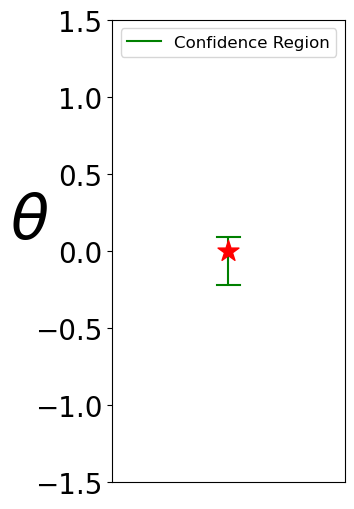

In [42]:
# The red star in the plot is the true parameter

plot_parameter_region(
    parameter_region=confidence_region[0],
    param_dim=PARAM_DIM,
    true_parameter=true_param_consistent,
    parameter_space_bounds=simulator.poi_space_bounds,
    figsize=(3, 6)
)

Central (Gaussian approximation) prediction sets

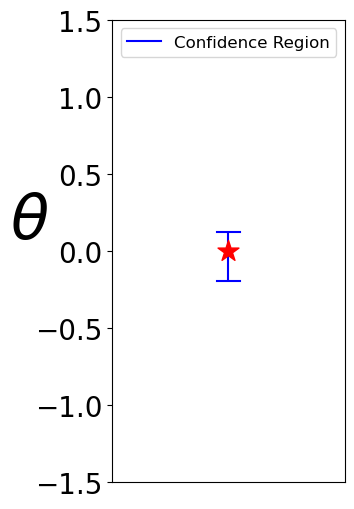

In [40]:
plot_parameter_region(
    parameter_region=gaussian_prediction_sets(
        conditional_mean_estimator=lf2i.test_statistic.estimator,
        conditional_variance_estimator=lf2i.test_statistic.cond_variance_estimator,
        samples=observed_x_consistent,
        confidence_level=CONFIDENCE_LEVEL,
        param_dim=PARAM_DIM
    ),
    param_dim=PARAM_DIM,
    true_parameter=true_param_consistent,
    parameter_space_bounds=simulator.poi_space_bounds,
    color='blue',
    figsize=(3, 6)
)

### Observation **NOT** consistent with the prior

Waldo Confidence Region

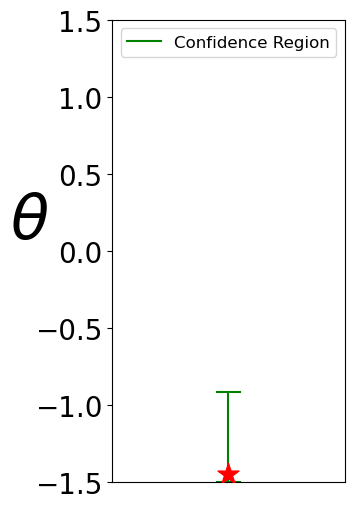

In [39]:
plot_parameter_region(
    parameter_region=confidence_region[1],
    param_dim=PARAM_DIM,
    true_parameter=true_param_notconsistent,
    parameter_space_bounds=simulator.poi_space_bounds,
    figsize=(3, 6)
)

Gaussian prediction intervals centered around the prediction. \
Different observations might give slightly different results, but on average this method does not provide the correct level of coverage (see Diagnostics below)

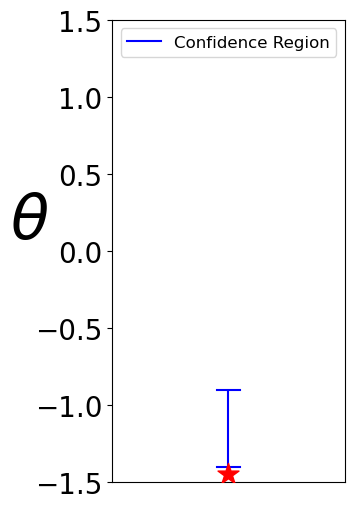

In [38]:
plot_parameter_region(
    parameter_region=gaussian_prediction_sets(
        conditional_mean_estimator=lf2i.test_statistic.estimator,
        conditional_variance_estimator=lf2i.test_statistic.cond_variance_estimator,
        samples=observed_x_notconsistent,
        confidence_level=CONFIDENCE_LEVEL,
        param_dim=PARAM_DIM
    ),
    param_dim=PARAM_DIM,
    true_parameter=true_param_notconsistent,
    parameter_space_bounds=simulator.poi_space_bounds,
    color='blue',
    figsize=(3, 6)
)

## DIAGNOSTICS

In [21]:
from lf2i.plot.coverage_diagnostics import coverage_probability_plot

### Central (Gaussian approximation) Prediction Sets

Note that for this example we are using the simulator to obtain training dataset. If one has pre-simulated dataset, it can be given as input directly to the `diagnostics` method.

In [20]:
diagnostic_estimator, parameters, mean_proba, upper_proba, lower_proba = lf2i.diagnostics(
    region_type='prediction',
    simulator=simulator,
    b_double_prime=10_000,
    evaluation_grid=simulator.poi_grid.reshape(-1, PARAM_DIM),
    confidence_level=CONFIDENCE_LEVEL
)

Coverage is close to the correct level (90%) only when the true parameter is close to the bulk of the prior distribution

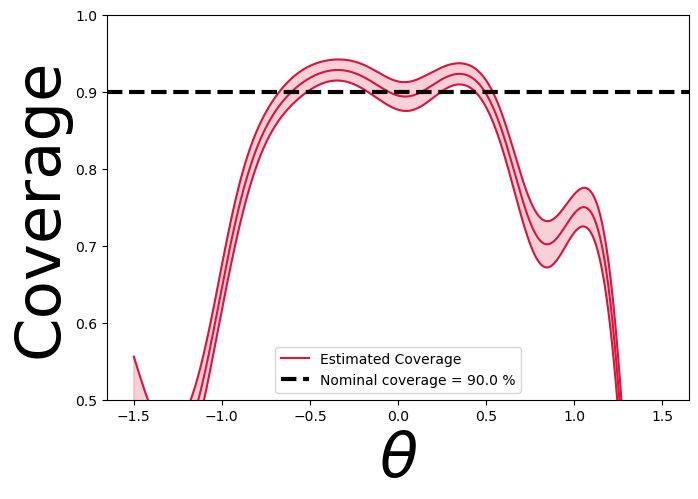

In [22]:
coverage_probability_plot(
    parameters=parameters,
    coverage_probability=mean_proba, 
    upper_proba=upper_proba,
    lower_proba=lower_proba,
    confidence_level=CONFIDENCE_LEVEL,
    param_dim=PARAM_DIM,
    figsize=(7.5, 5),
    ylims=(0.5, 1)
)

### Waldo Confidence Regions

Note that for this example we are using the simulator to obtain training dataset. If one has pre-simulated dataset, it can be given as input directly to the `diagnostics` method.

In [24]:
diagnostic_estimator, parameters, mean_proba, upper_proba, lower_proba = lf2i.diagnostics(
    region_type='lf2i',
    simulator=simulator,
    b_double_prime=10_000,
)

Coverage is approximately the correct level (90%) everywhere

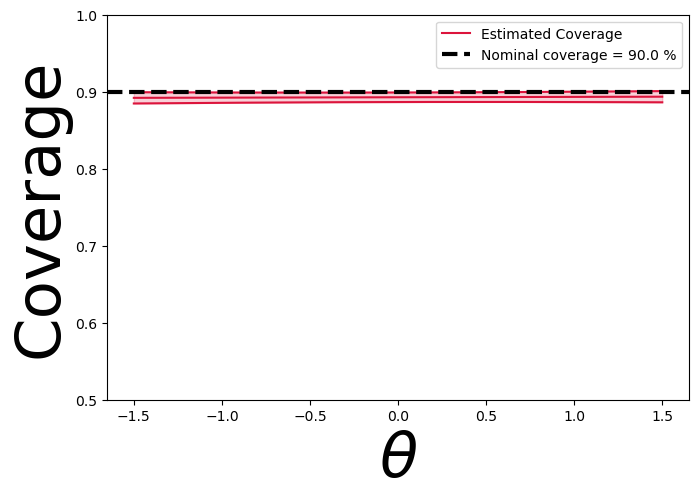

In [26]:
coverage_probability_plot(
    parameters=parameters,
    coverage_probability=mean_proba, 
    upper_proba=upper_proba,
    lower_proba=lower_proba,
    confidence_level=CONFIDENCE_LEVEL,
    param_dim=PARAM_DIM,
    figsize=(7.5, 5),
    ylims=(0.5, 1)
)